In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/my_data/train_df.csv')
data

,Unnamed: 0,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,PromoOpen,CompetitionOpen
0,0,1,c,a,1270.0,9.0,2008.0,0,14.0,2012.0,"Jan,Apr,Jul,Oct",4,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,40.25,82.0
1,1,1,c,a,1270.0,9.0,2008.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",3,2015-07-30,5020,546,1,1,0,1,2015,7,30,31,38.25,82.0
2,2,1,c,a,1270.0,9.0,2008.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",2,2015-07-29,4782,523,1,1,0,1,2015,7,29,31,38.25,82.0
3,3,1,c,a,1270.0,9.0,2008.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",1,2015-07-28,5011,560,1,1,0,1,2015,7,28,31,38.25,82.0
4,4,1,c,a,1270.0,9.0,2008.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",0,2015-07-27,6102,612,1,1,0,1,2015,7,27,31,38.25,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1017204,1115,d,c,5350.0,4.0,2006.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5,2013-01-05,4771,339,1,0,0,1,2013,1,5,1,6.75,81.0
1017205,1017205,1115,d,c,5350.0,4.0,2006.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",4,2013-01-04,4540,326,1,0,0,1,2013,1,4,1,6.75,81.0
1017206,1017206,1115,d,c,5350.0,4.0,2006.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",3,2013-01-03,4297,300,1,0,0,1,2013,1,3,1,6.75,81.0
1017207,1017207,1115,d,c,5350.0,4.0,2006.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2,2013-01-02,3697,305,1,0,0,1,2013,1,2,1,6.75,81.0


Isolate the Rossmann Store Sales dataset into time series data

In [ ]:
sales_ts=data[['Date','Sales']].copy()
sales_ts.set_index('Date')

,Sales
Date,
2015-07-31,5263
2015-07-30,5020
2015-07-29,4782
2015-07-28,5011
2015-07-27,6102
...,...
2013-01-05,4771
2013-01-04,4540
2013-01-03,4297


In [ ]:

scaler = MinMaxScaler()
scaler.fit(sales_ts.Sales.values.reshape([-1, 1]))
SalesScaled = scaler.transform(sales_ts.Sales.values.reshape(-1, 1))
sales_ts['ScaledSales'] = SalesScaled
sales_ts.head()
sales_ts1=sales_ts.head(100000)

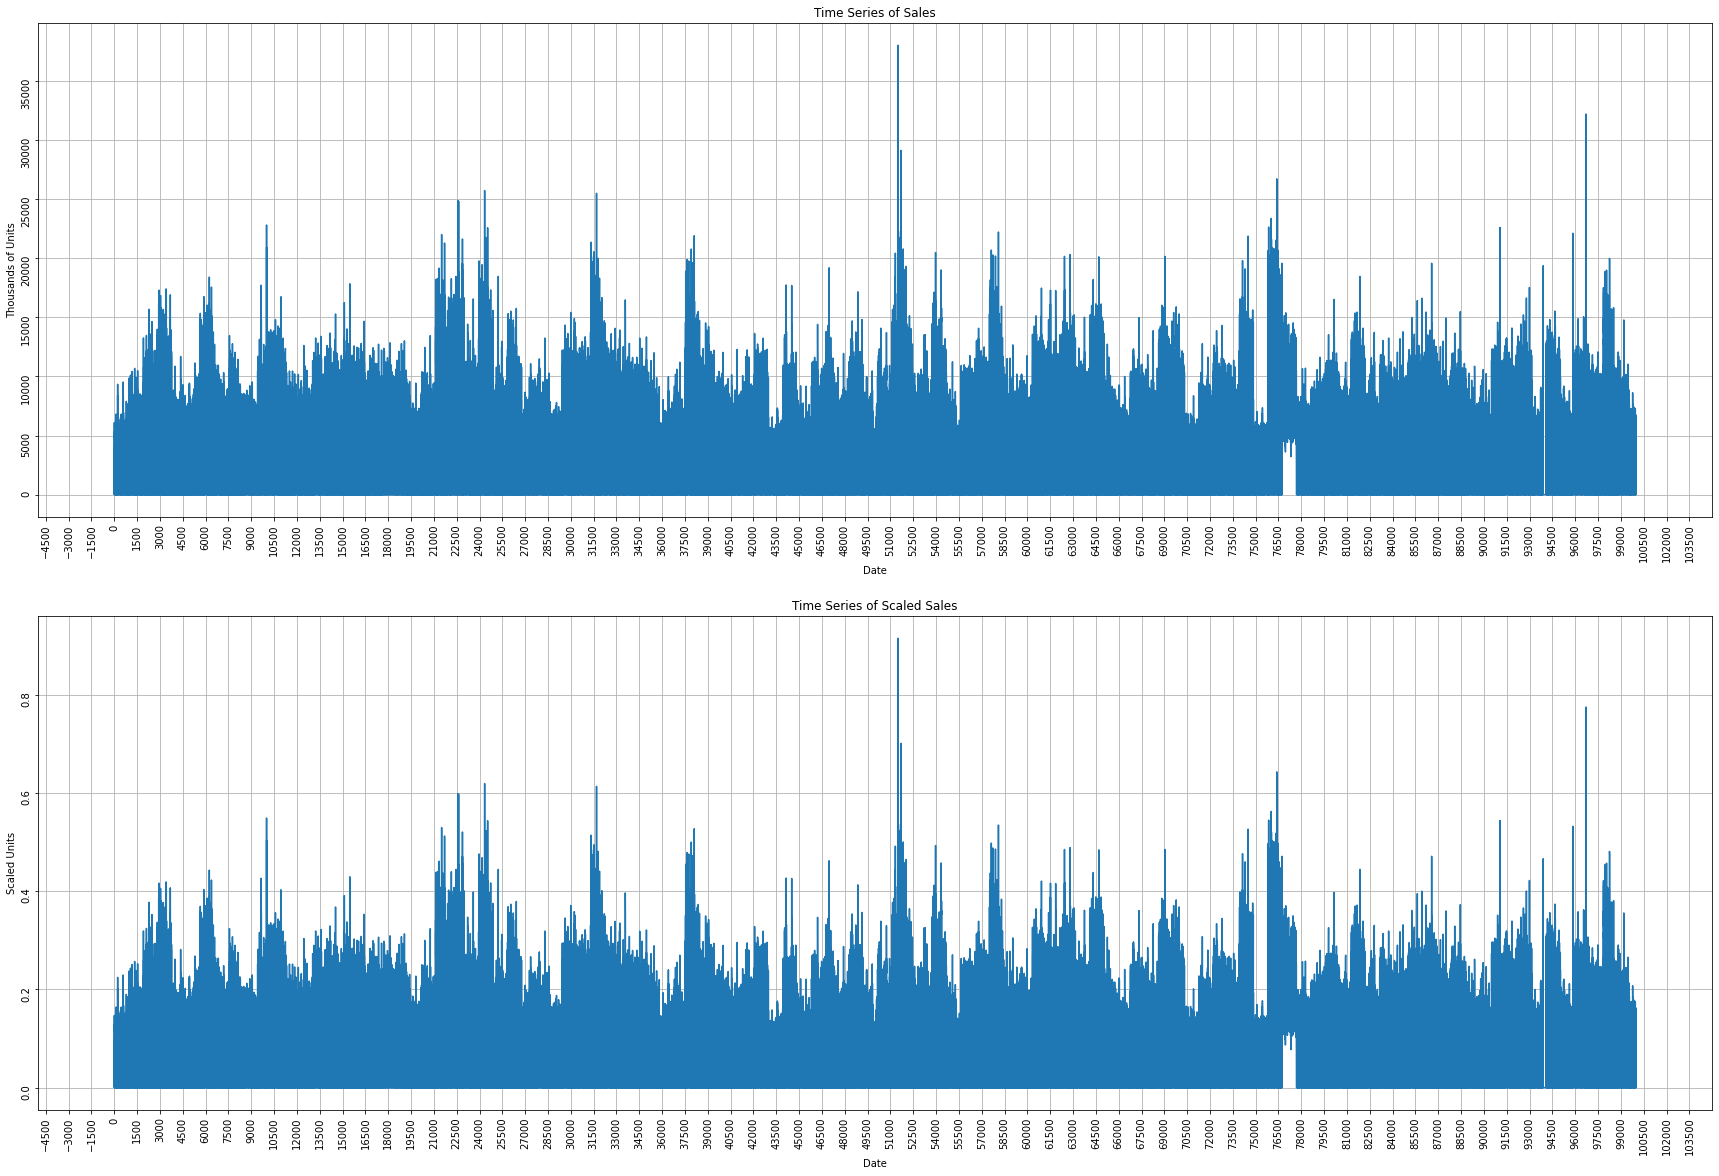

In [ ]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(sales_ts1.index, sales_ts1.Sales)
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series of Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(sales_ts1.index, sales_ts1.ScaledSales)
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series of Scaled Sales')
ax2.grid(True)
plt.show()

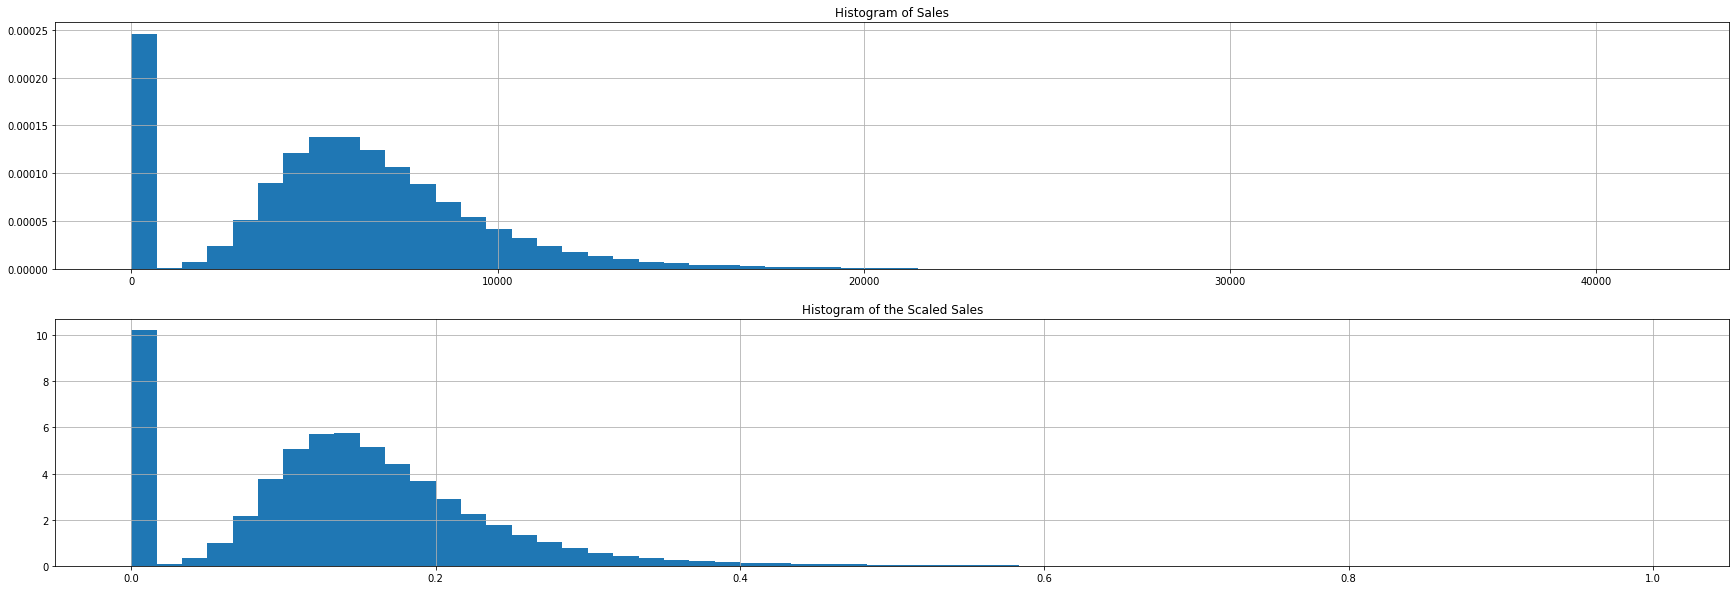

In [ ]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(sales_ts.Sales, density=True, bins=60)
ax1.title.set_text('Histogram of Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(sales_ts.ScaledSales, density=True, bins=60)
ax2.title.set_text('Histogram of the Scaled Sales')
ax2.grid(True)
plt.show()

Check whether your time Series Data is Stationary


In [ ]:
adfResult = adfuller(sales_ts1.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -10.620581349398723
p-value: 5.52887048495825e-19


p-value is less than 0.05, the data has stationarity,so we remove stationarity by differencing


In [ ]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)
 

StoreSalesDif = difference(sales_ts1.ScaledSales.values) 
StoreSalesDif

0       -0.005848
1       -0.005728
2        0.005511
3        0.026257
4       -0.146856
           ...   
99994   -0.005198
99995   -0.092056
99996    0.069336
99997    0.032947
99998    0.015740
Length: 99999, dtype: float64

Check for autocorrelation and partial autocorrelation of the data

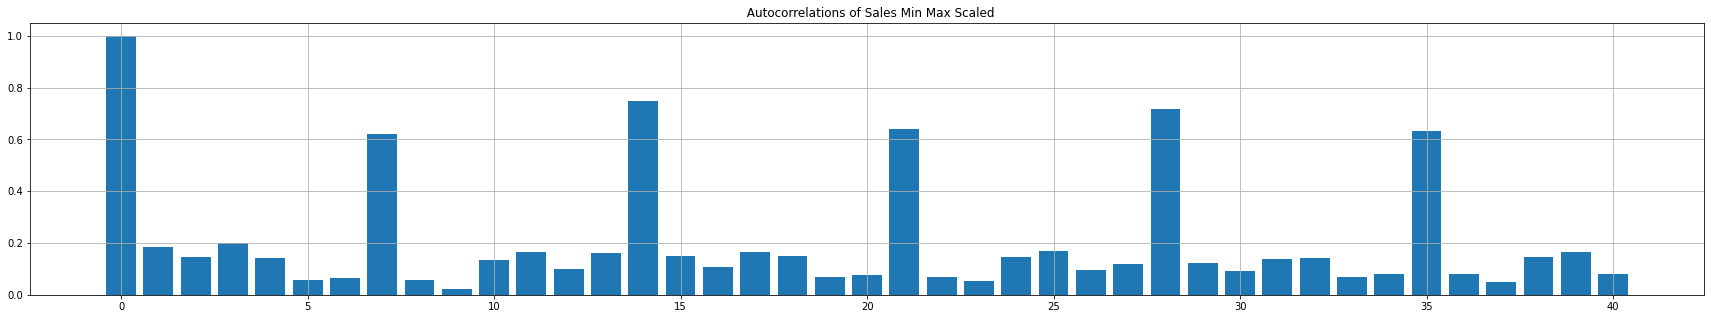

In [ ]:
acfSalesScaled = acf(sales_ts1.ScaledSales.values, fft=True,nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

corrPlots(acfSalesScaledNp, '')    

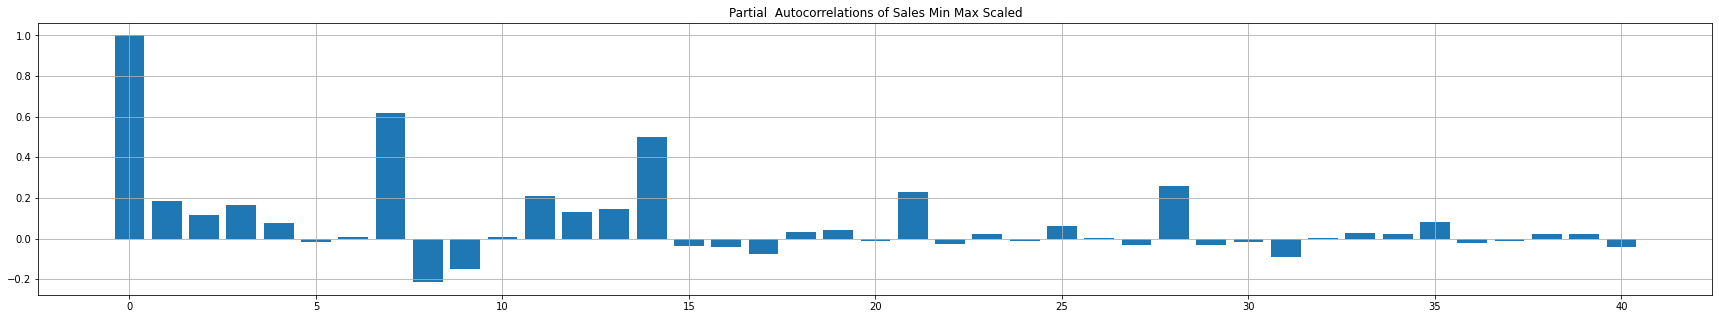

In [ ]:
pacfSalesScaled = pacf(sales_ts1.ScaledSales.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

corrPlots(pacfSalesScaledNp, "Partial")

Transform the time series data into supervised learning data

In [ ]:
SIZE = len(sales_ts1.ScaledSales)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 100

In [ ]:
DateTrain = sales_ts1.index.values[0:BATCH_SIZE]
DateValid = sales_ts1.index.values[BATCH_SIZE:]
XTrain = sales_ts1.ScaledSales.values[0:BATCH_SIZE].astype('float32')
XValid = sales_ts1.ScaledSales.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (99904, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (99904,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [ ]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([99904, 1])

In [ ]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
DatasetTrain=windowed_dataset(XTrain)
DatasetVal=windowed_dataset(XValid)

In [ ]:
DatasetTrain

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>

In [ ]:
DatasetVal

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>

Build a LSTM Regression model to predict the next sale.

In [ ]:
#defining the model
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
#loss function
model.compile(loss="huber_loss", optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 8)           320       
_________________________________________________________________
lstm_5 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/100
1/1 [==============================] - 20s 20s/step - loss: 0.0191 - val_loss: 0.0062
Epoch 2/100
1/1 [==============================] - 16s 16s/step - loss: 0.0179 - val_loss: 0.0056
Epoch 3/100
1/1 [==============================] - 16s 16s/step - loss: 0.0167 - val_loss: 0.0050
Epoch 4/100
1/1 [==============================] - 17s 17s/step - loss: 0.0156 - val_loss: 0.0044
Epoch 5/100
1/1 [==============================] - 17s 17s/step - loss: 0.0146 - val_loss: 0.0039
Epoch 6/100
1/1 [==============================] - 16s 16s/step - loss: 0.0136 - val_loss: 0.0035
Epoch 7/100
1/1 [==============================] - 17s 17s/step - loss: 0.0126 - val_loss: 0.0030
Epoch 8/100
1/1 [==============================] - 17s 17s/step - loss: 0.0117 - val_loss: 0.0027
Epoch 9/100
1/1 [==============================] - 17s 17s/step - loss: 0.0109 - val_loss: 0.0023
Epoch 10/100
1/1 [==============================] - 17s 17s/step - loss: 0.0101 - val_loss: 0.0020
Epoch 11/100
1/1 [=

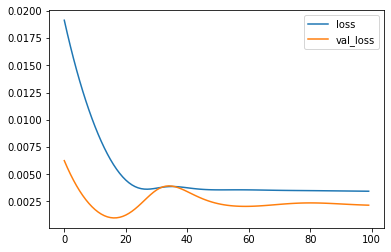

In [57]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [58]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [59]:
Forecast = model_forecast(model, sales_ts1.ScaledSales.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

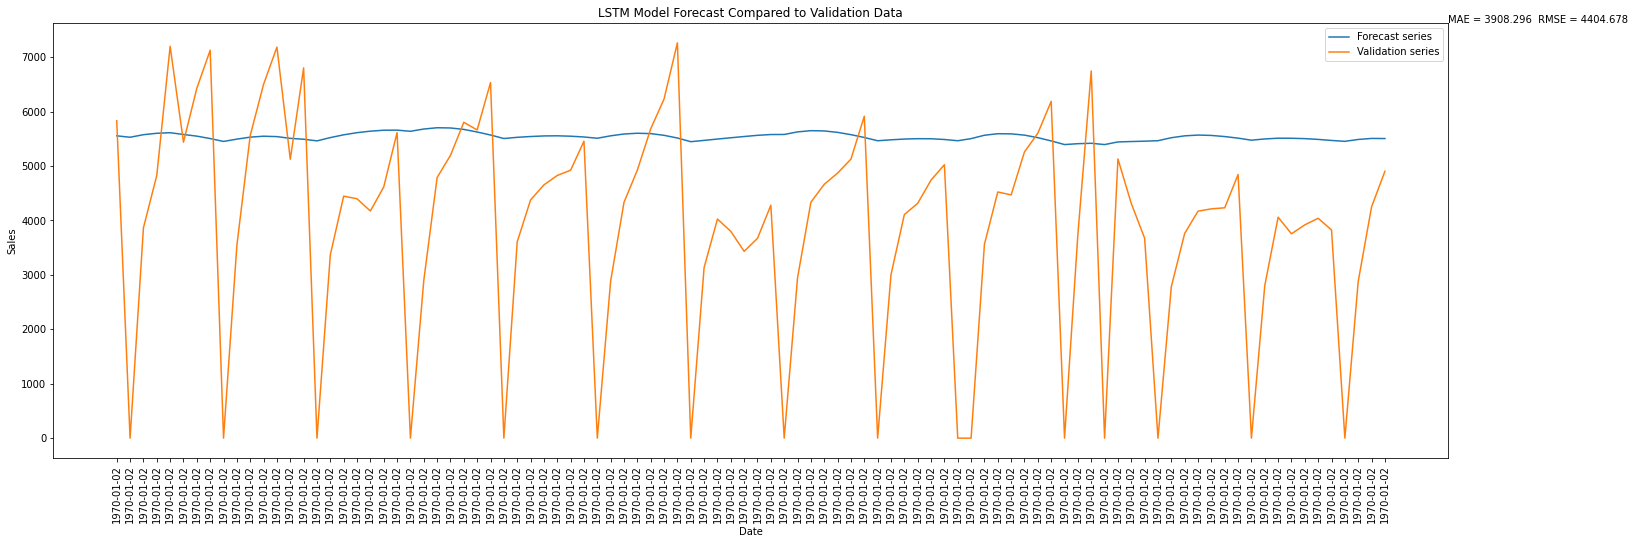

MAE = 3908.296  RMSE = 4404.678


In [72]:
plt.figure(figsize=(25, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

textstr

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(1,1), xycoords='axes fraction')
plt.show()

print(textstr)